## Movie Classifier: Overview

Tasks Performed:
1. Pre-processing the data:
   
   - Detected descriptions which are in different languages using langdetect python library.
   - Converted these descriptions to English using googletrans library's Translator.
   - Did traditional pre-processing of the data: Lowercasing, Removing twitter handles, stopwords, URLs, extra spaces, etc.
   - Encoded the categories
   

2. Indexing the Vocuabulary:
    - Using the TextVectorization to index the vocabulary found in the dataset. 
    - Later, we used the same layer instance to vectorize the samples.
    - Our layer will only consider the top 20,000 words, and will truncate or pad sequences to be actually 200 tokens long.
    - We use tensorflow.keras.layers.TextVectorization

3. Embedding:
    - Used pre-trained GLOVE Embeddings. Found 400000 word vectors 
    - Created the Embedding Matrix: Words not found in embedding index will be all-zeros. This includes the representation for "padding" and "OOV".
    - Created tensorflow.keras.layers.Embedding layer and embedded the text sequences.

4. Modelling:
   
   Model Summary:
     - input_1 (InputLayer)                                                                    
     - embedding (Embedding Layer)                                       
     - bidirectional (Bidirectional LSTM layer)                                                                    
     - dense (Dense)   
     - dropout (Dropout)      
     - dense_1 (Dense) 

5. Evaluation:
    - Test Accurracy: 59.12%

## I. Initial pre-processing of the Data

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import random
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

In [38]:
#Loading the dataset
df=pd.read_csv('train_data.txt',sep=':::',names=['Index','Title','Genre','Description'])

In [6]:
mov = df.copy()

In [7]:
mov['Description'][0]

" Jeremy Lin retires from basketball, not to play professionally in other sports as Michael Jordan did but to spend more time on his hobbies - watching anime and playing video games. One day, Lin gets sucked in to his computer and finds himself in the anime world. He finds Naruto, Sailor Moon, Goku, and Yugi who needs to settle a dispute with someone in a basketball game. The problem is the five doesn't know about the fundamentals of basketball and Jeremy Lin must guide the troupe."

In [39]:
mov.shape[0]

54214

### Detecting the Movie Descriptions which are in different language

In [57]:
#to detect data of different language
from langdetect import detect
def detect_my(text):
   try:
       return detect(text)
   except:
       return 'unknown'

In [58]:
mov['Language']= mov['Description'].apply(detect_my)

In [59]:
mov[mov['Language']!='en']

,Index,Title,Genre,Description,Language
210,211,Divorzio alla siciliana (1963),comedy,Il barone Fifě ha bisogno di un erede per ave...,it
242,243,Túlvilági beszélö (1992),documentary,Mail <svaradi@sprynet.com> for translation. T...,hu
282,283,"""Boogie-woogie 47"" (1980)",drama,"En 1947, plusieurs familles de Montréal passe...",fr
678,679,Pallati 176 (1986),comedy,English: A comedy by well-known Albanian thea...,sq
806,807,Iszony (1965),drama,Mail to author for translation Karasz Nelli a...,hu
...,...,...,...,...,...
53697,53698,Fantasmi e ladri (1959),comedy,Annunziata ha letto diecimila gialli e spopol...,it
53712,53713,Due notti con Cleopatra (1954),comedy,Cleopatra č una donna bellissima ma ha un pic...,it
53878,53879,Gyilkos kedv (1997),drama,Kora delutan egy iskolabol hazatero kislany c...,hu
54165,54166,Az áldozat (1994),documentary,Mail author for translation. Az 1956-os forra...,hu


### Translating these descriptions to English 

In [60]:
#Translating the non english description into english
import googletrans
from googletrans import Translator
#mov['Description']=mov['Description'].apply(lambda x: translator.translate(x, dest='en').text )
for i in range(0,mov.shape[0]):
    if mov['Language'][i]!='en':
        mov['Description'][i]=translator.translate(mov['Description'][i],dest='en').text 



In [62]:
mov.drop('Language',axis=1,inplace=True)  #Dropping the Language DataFrame
#mov.to_csv("Movies_en.csv")

In [2]:
df=pd.read_csv('Movies_en.csv')
# markov_df.to_csv('aug_df.csv')

In [3]:
df.shape

(54214, 5)

### Train Data Value Counts

In [10]:
print(df['Genre'].value_counts())

Genre
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64


### Data Preprocessing

In [4]:
mov = df.copy()
#mov = mov.iloc[0:105046,:]

In [5]:
mov['Description'][0]

' Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.'

In [6]:
mov.shape[0]

54214

In [8]:
import string
def clean_text(text):
    text = text.lower()                                  # lower-case all characters
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return text

In [9]:
#Applying the above clean_text method for cleaning and preprocessing the Description column of the dataset that is being subjected to the model
mov['clean_description'] = mov['Description'].apply(clean_text)


### Encode the Categories 

In [11]:
# Create a new column 'category_id' with encoded categories
mov['category_id'] = mov['Genre'].factorize()[0]

In [12]:
# Dictionaries for future use
category_id_df = mov[['Genre', 'category_id']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Genre']].values)


In [13]:
print(category_to_id)

{' drama ': 0, ' thriller ': 1, ' adult ': 2, ' documentary ': 3, ' comedy ': 4, ' crime ': 5, ' reality-tv ': 6, ' horror ': 7, ' sport ': 8, ' animation ': 9, ' action ': 10, ' fantasy ': 11, ' short ': 12, ' sci-fi ': 13, ' music ': 14, ' adventure ': 15, ' talk-show ': 16, ' western ': 17, ' family ': 18, ' mystery ': 19, ' history ': 20, ' news ': 21, ' biography ': 22, ' romance ': 23, ' game-show ': 24, ' musical ': 25, ' war ': 26}


### Create Dependent and Independent feature dataframes

In [14]:
## Get the Dependent and Independent features 
y=mov['category_id']
X=mov['clean_description']

In [15]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## II. Creating a vocabulary index


In [17]:
#Using the TextVectorization to index the vocabulary found in the dataset. 
#Later, we'll use the same layer instance to vectorize the samples.
#Our layer will only consider the top 20,000 words, and will truncate or pad sequences 
#to be actually 200 tokens long.

from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

2023-11-16 22:41:47.216518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [18]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'life', 'one', 'film']

In [19]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [22]:
output = vectorizer([["I love Indian Food"]])
output.numpy()

array([[  1,  10, 752, 408,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

## III. Embedding the data

### Loading the pre-trained GLOVE Embeddings

In [23]:
import os
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/Users/dibyanshu/Documents/Jupyter Codes/NLP/glove.6B/glove.6B.200d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


### Creating the Embedding Matrix

In [24]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19787 words (213 misses)


### Creating the Embedding Layer

In [25]:
from tensorflow.keras.layers import Embedding
import keras
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

## IV. Modelling

In [26]:
from tensorflow.keras import layers

# Creating model
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(LSTM(100))(embedded_sequences)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(27, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 200)         4000400   
                                                                 
 bidirectional (Bidirection  (None, 200)               240800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                             

### Vectorising the data

In [27]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_val = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_test)

### Fitting the Model

In [28]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5


2023-11-16 22:42:47.767048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 22:42:48.049438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 22:42:48.108385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 22:42:50.808248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 22:42:50.822790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


284/284 [==============================] - ETA: 0s - loss: 1.9180 - acc: 0.4605

2023-11-16 22:44:30.831928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 22:44:30.957929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 22:44:30.998126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


284/284 [==============================] - 110s 362ms/step - loss: 1.9180 - acc: 0.4605 - val_loss: 1.6067 - val_acc: 0.5328
Epoch 2/5
284/284 [==============================] - 85s 300ms/step - loss: 1.5237 - acc: 0.5592 - val_loss: 1.4567 - val_acc: 0.5688
Epoch 3/5
284/284 [==============================] - 73s 255ms/step - loss: 1.3295 - acc: 0.6100 - val_loss: 1.3962 - val_acc: 0.5838
Epoch 4/5
284/284 [==============================] - 66s 232ms/step - loss: 1.1826 - acc: 0.6518 - val_loss: 1.3682 - val_acc: 0.5931
Epoch 5/5
284/284 [==============================] - 63s 223ms/step - loss: 1.0537 - acc: 0.6886 - val_loss: 1.4208 - val_acc: 0.5912


## V. Evaluation

### Test Data Validation

In [31]:
#y_pred=model.predict(X_test)
y_pred=model.predict(x_val)

2023-11-16 22:49:58.537126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 22:49:58.683518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 22:49:58.706576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


560/560 [==============================] - 12s 19ms/step


In [32]:
y_pred

array([[3.3842787e-01, 2.6631859e-01, 1.2558341e-02, ..., 7.0602786e-05,
        4.6238455e-04, 5.7916419e-05],
       [7.9520470e-01, 4.8521045e-03, 1.2569671e-03, ..., 5.6822328e-06,
        1.5580592e-03, 1.0342008e-04],
       [2.0679317e-02, 9.6977856e-03, 9.1187535e-03, ..., 4.3359742e-04,
        2.7906990e-03, 3.7548249e-04],
       ...,
       [7.4810112e-01, 4.5555574e-03, 1.1045377e-03, ..., 5.5015869e-05,
        5.8568139e-03, 2.1295799e-03],
       [2.5704688e-01, 6.4409807e-02, 7.3263724e-04, ..., 3.0026969e-04,
        1.5303037e-03, 4.0232692e-02],
       [2.2442985e-02, 4.7985530e-03, 2.1680152e-02, ..., 3.7444636e-04,
        1.8713679e-03, 6.6583445e-05]], dtype=float32)

In [33]:
y_pred_labels = [np.argmax(y_pred[i]) for i in range(0,len(y_pred))]

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
accuracy_score(y_val,y_pred_labels)

0.5912469956961601

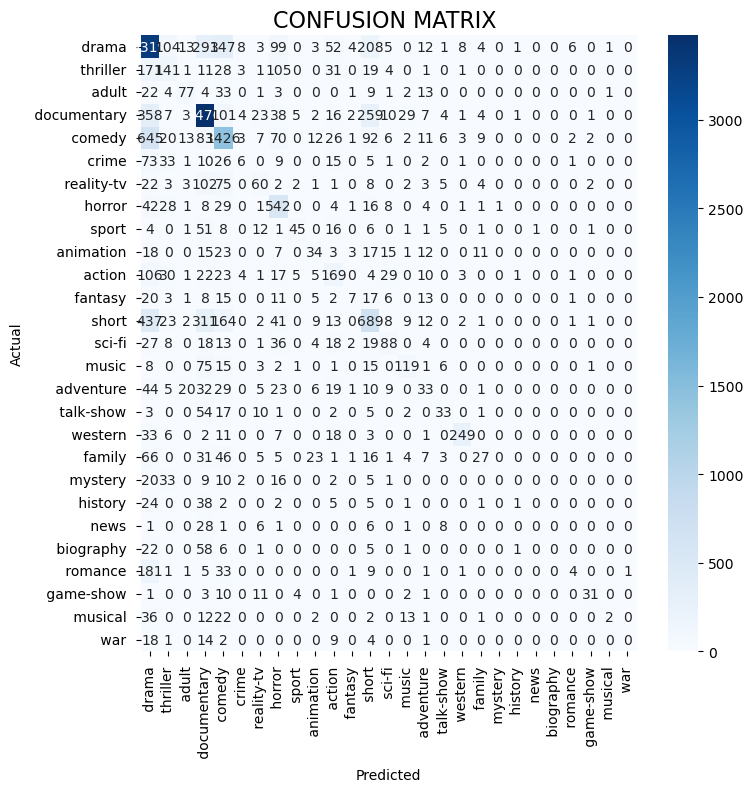

In [35]:
conf_mat = confusion_matrix(y_test, y_pred_labels)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Genre.values,
            yticklabels=category_id_df.Genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX ", size=16);

In [37]:
from sklearn import metrics
print(metrics.classification_report(y_val, y_pred_labels,target_names= df['Genre'].unique()))

               precision    recall  f1-score   support

       drama        0.58      0.74      0.65      4489
    thriller        0.31      0.27      0.29       517
       adult        0.56      0.45      0.50       171
 documentary        0.73      0.80      0.76      4351
      comedy        0.57      0.58      0.58      2439
       crime        0.20      0.03      0.06       183
  reality-tv        0.39      0.20      0.27       295
      horror        0.52      0.79      0.63       687
       sport        0.73      0.29      0.42       154
   animation        0.32      0.21      0.26       159
      action        0.40      0.39      0.40       431
     fantasy        0.29      0.06      0.11       109
       short        0.47      0.40      0.43      1725
      sci-fi        0.46      0.37      0.41       238
       music        0.63      0.48      0.55       247
   adventure        0.22      0.14      0.17       237
   talk-show        0.46      0.26      0.33       128
     west